# Análisis STUDENT ALCOHOL CONSUMPTION

Javier Cano Montero [javier.cano.montero@gmail.com]

## Objetivos del análisis

Usando el dataset de STUDENT ALCOHOL CONSUMPTION 

**Objetivo 1**: Realizar un análisis exploratorio con el que explicar los datos y conclusiones que se puedan sacar de ellos. 

**Objetivo 2**: Realizar una predicción sobre los valores objetivo (G1, G2 y G3). Puede realizarse una regresión o ajustar las notas para convertirse a un "aprobado / no aprobado".

Se pueden usar notebooks en R o Python indistintamente, pero los resultados deben ser reproducibles. 

## Objetivo 1:

El dataset está formado por dos ficheros con información del rendimiento de alumnos de dos asignaturas. Cada uno de los ficheros corresponde a una asignatura, el fichero 'student-mat.csv' contiene información de la asignatura de matemáticas y el fichero 'student-por.csv' contiene información de portugués.

Las variables *TARGET* G1, G2 y G3 son las notas de las asignaturas correspondientes al primer período, segundo período y nota final.

Ambos ficheros se encuentran en el subdirectorio **data** junto a un diccionario de datos. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
%matplotlib inline

Leemos los ficheros csv y los cargamos en sus dataframes.

In [3]:
mat = pd.read_csv("../data/student-mat.csv", sep=";")
por = pd.read_csv("../data/student-por.csv", sep=";")

### Pretratamiento

Lo primero es comprobar si los ficheros contienen algún valor "NA".

In [4]:
print(mat.isnull().values.any())
print(por.isnull().values.any())

False
False


No existen "NAs". Para la segunda parte del ejercicio creamos una parte categórica en la que se indica si el alumno aprobó la asignatura (tiene una nota superior o igual a 10).

In [5]:
mat["G1_pass"]=mat["G1"]>=10
mat["G2_pass"]=mat["G2"]>=10
mat["G3_pass"]=mat["G3"]>=10
por["G1_pass"]=por["G1"]>=10
por["G2_pass"]=por["G2"]>=10
por["G3_pass"]=por["G3"]>=10

### Análisis

A continuación definimos la función que realizará un análisis descriptivo de los ficheros de datos. Realizaremos un histograma de las variables numéricas y categóricas para ver su distribución. Finalmente realizamos un análisis de correlación, para ver qué variables están correlacionadas entre sí y con las variables *TARGET*.

In [6]:
def make_analysis(df):
    print('Variables numéricas')
    for i in df.columns[df.dtypes=='int64']:
        fig, ax = plt.subplots()
        ax = mat[i].hist()
        ax.set_title(i)
        plt.show()

    print('Variables categóricas')
    for i in df.columns[df.dtypes=='object']:
        fig, ax = plt.subplots()
        ax = mat[i].hist()
        ax.set_title(i)
        plt.show()
        
    corr = df.corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)


Variables numéricas


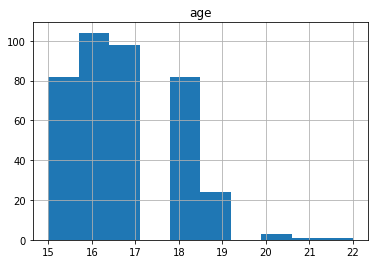

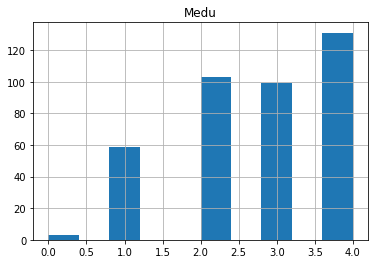

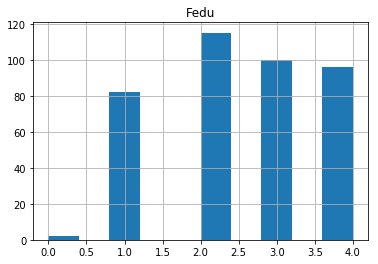

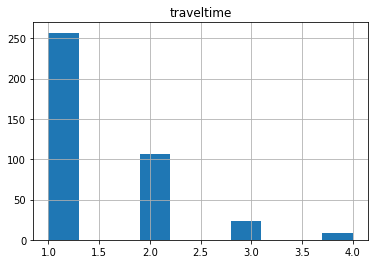

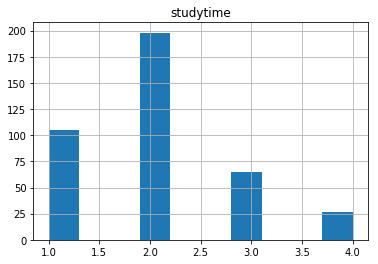

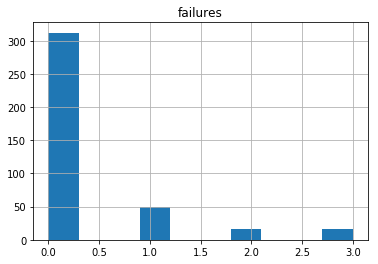

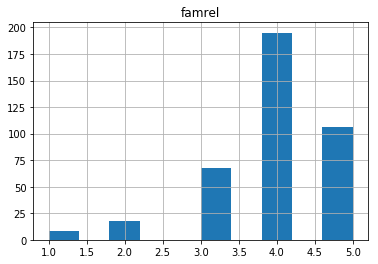

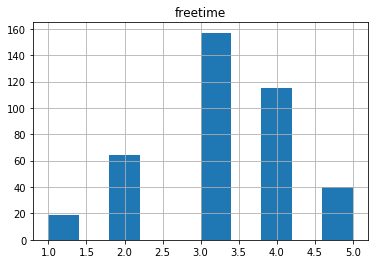

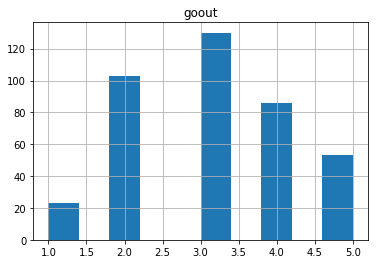

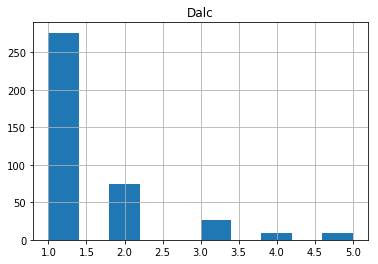

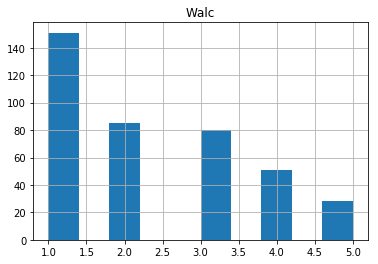

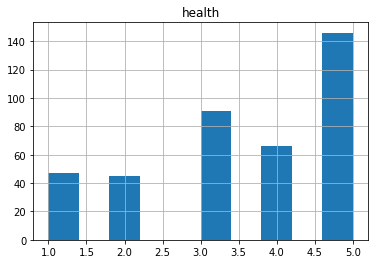

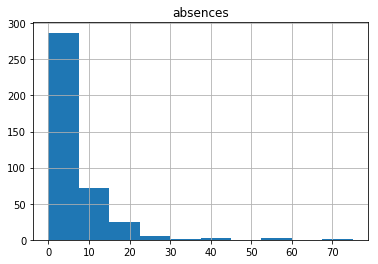

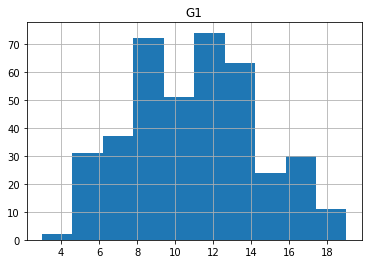

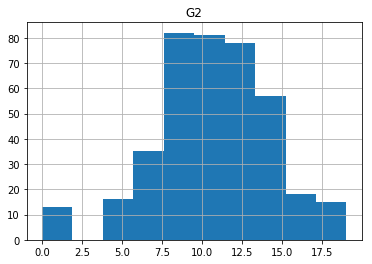

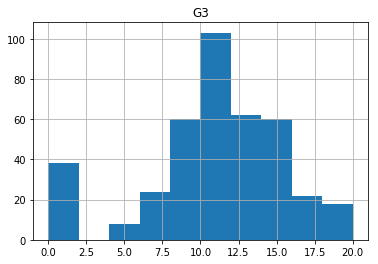

Variables categóricas


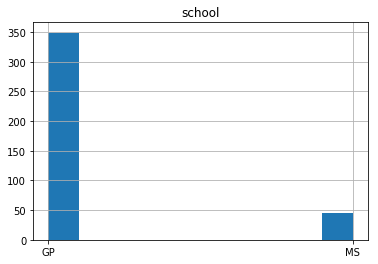

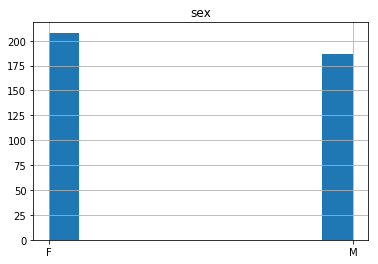

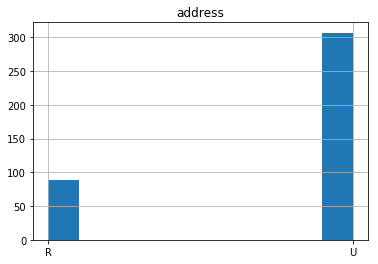

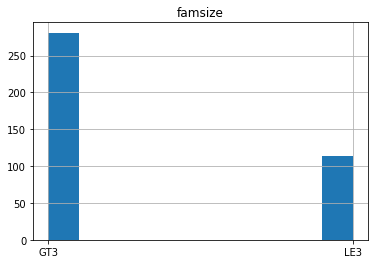

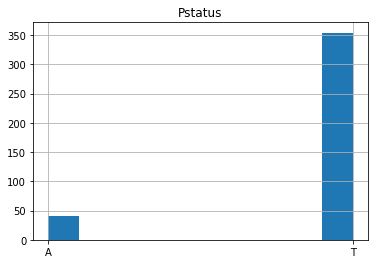

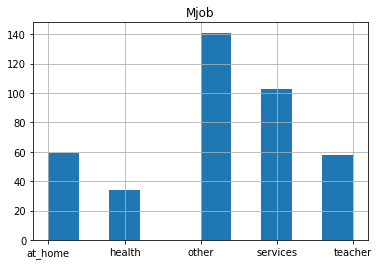

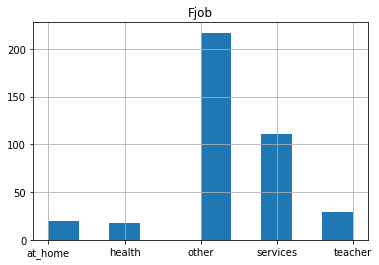

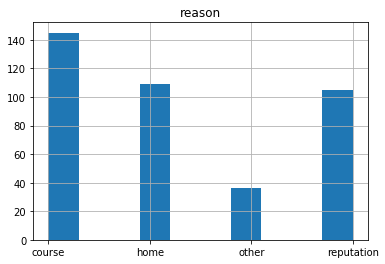

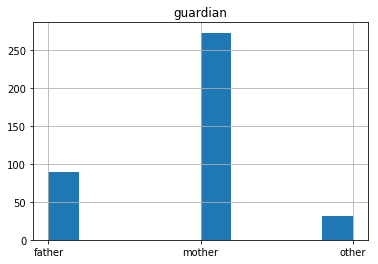

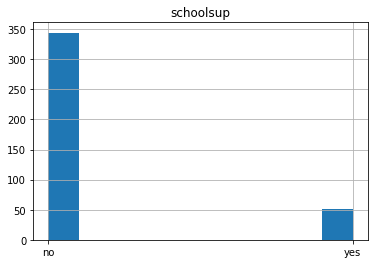

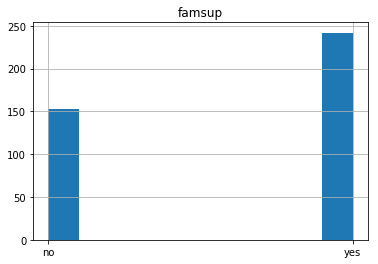

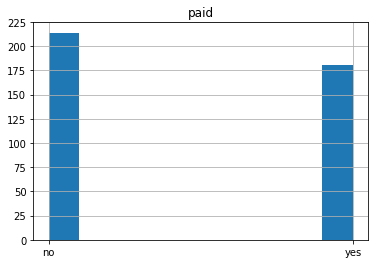

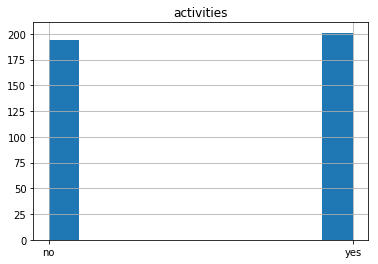

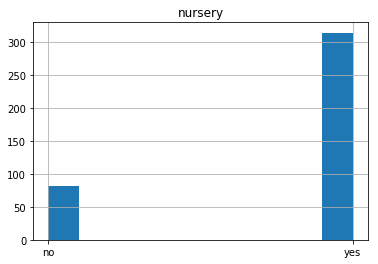

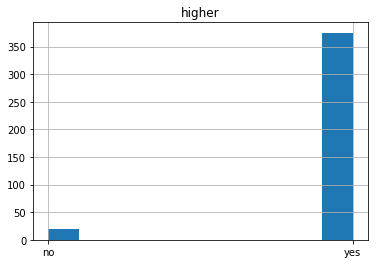

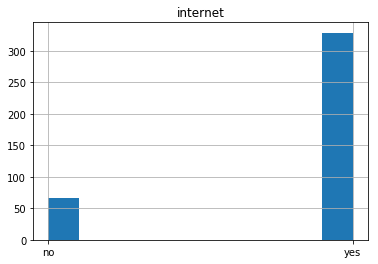

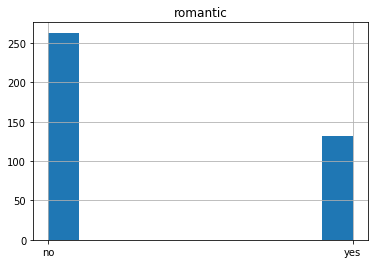

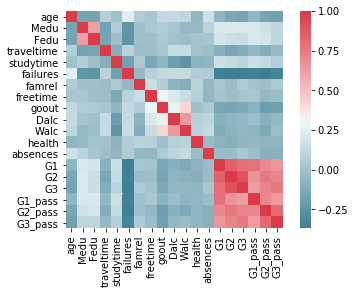

In [7]:
make_analysis(mat)

Variables numéricas


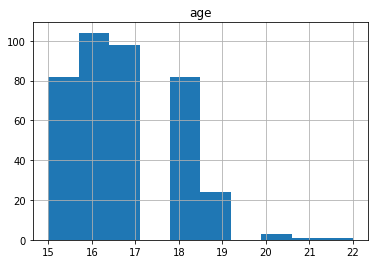

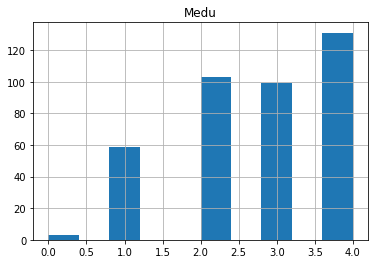

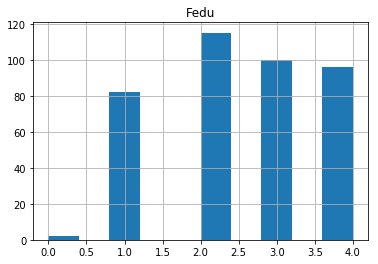

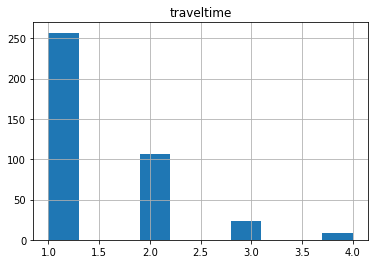

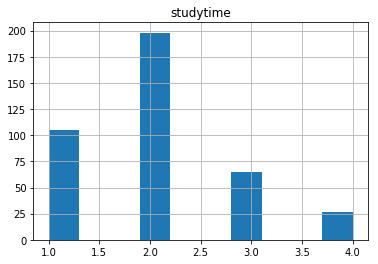

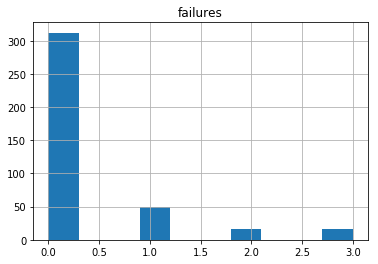

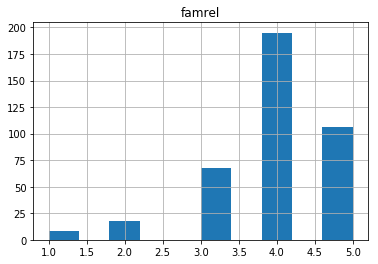

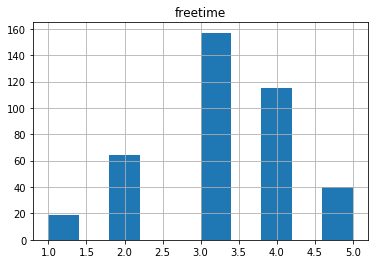

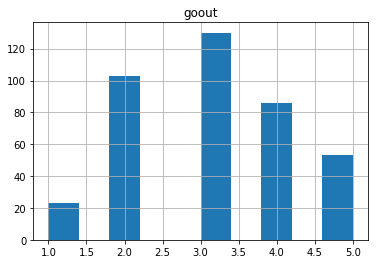

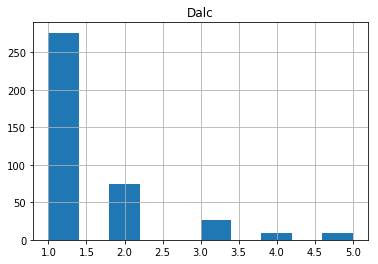

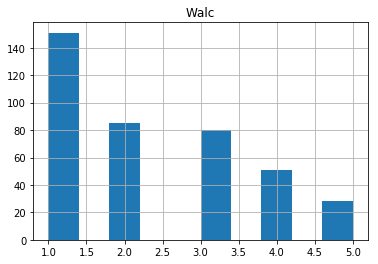

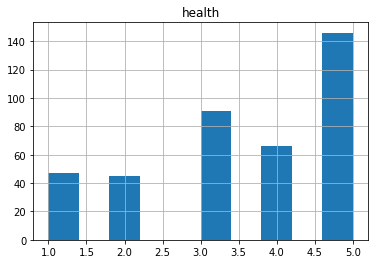

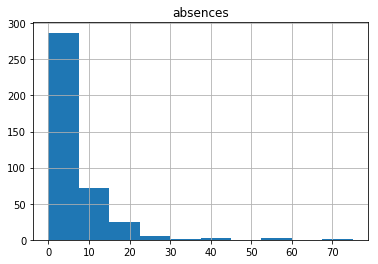

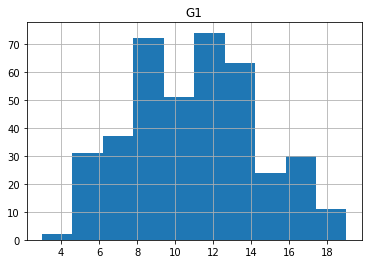

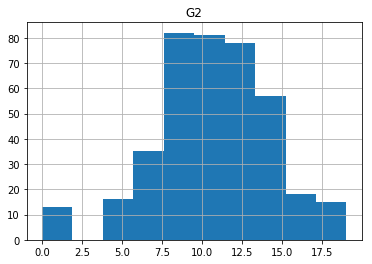

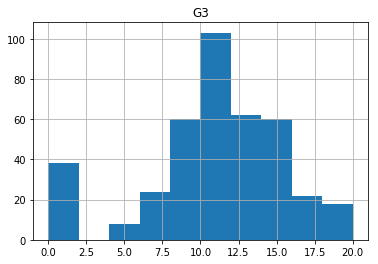

Variables categóricas


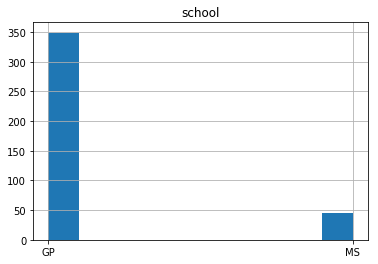

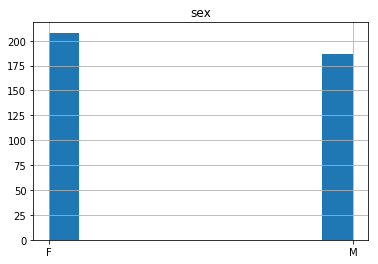

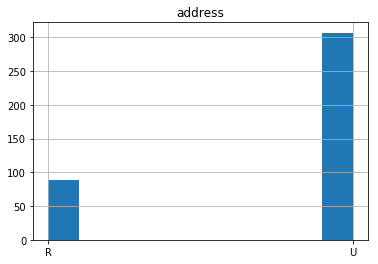

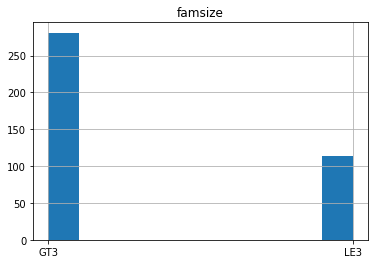

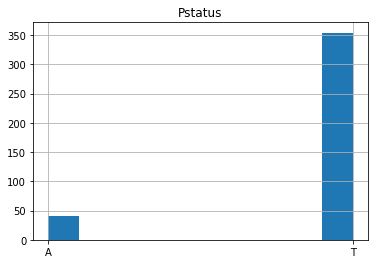

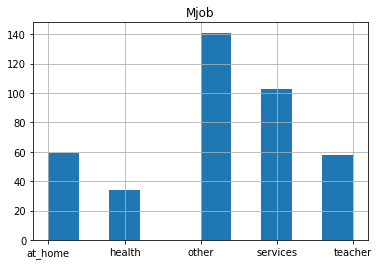

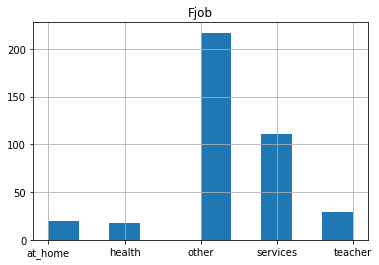

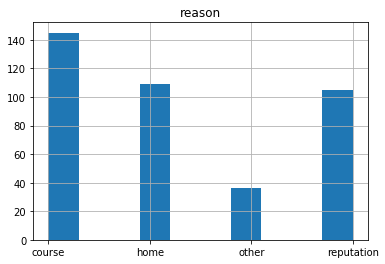

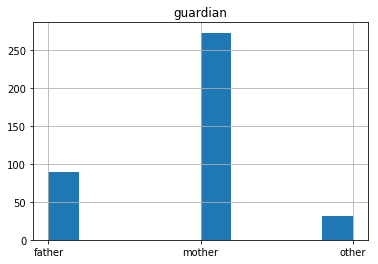

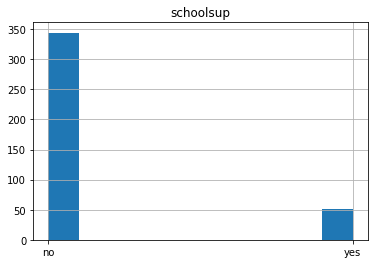

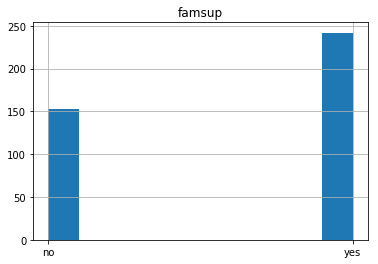

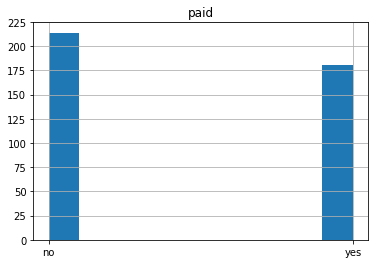

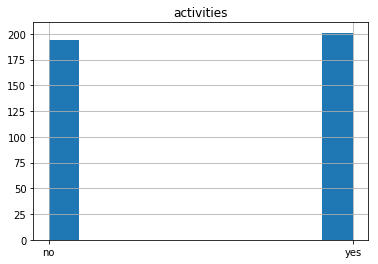

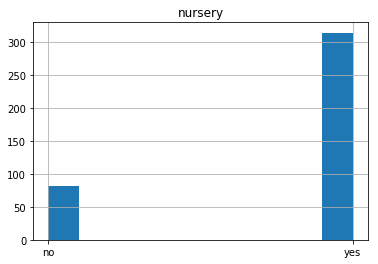

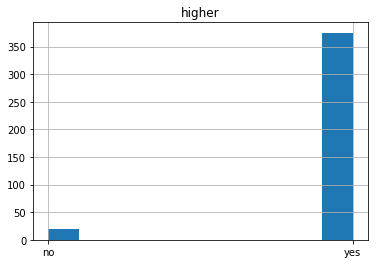

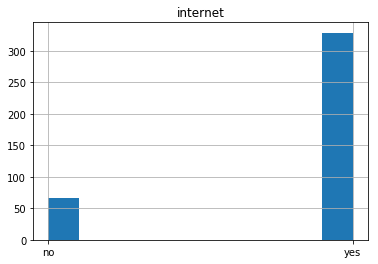

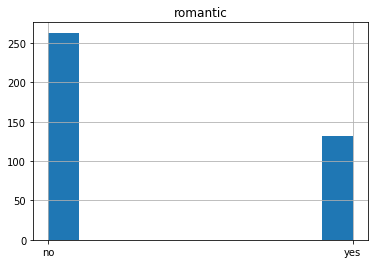

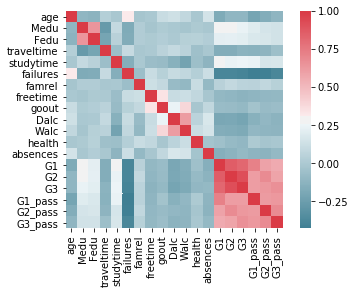

In [8]:
make_analysis(por)

Se observa en la distribución de las variables que algunas variables numéricas son factores reconvertidos a numéricos (mencionado en el diccionario) y que las variables puramente numéricas ('age', 'absences' y las variables *TARGET*) solo 'absences' no tiene una distribución normal, así que vamos a proceder a normalizarla. 

También se observa que no hay una correlación muy fuerte entre las variables *TARGET* y las otras variables. La única que tiene algo de correlación es 'failures', lo que significa que cuantas más veces se haya suspendido la asignatura, más probable es que se apruebe. 

In [9]:
mat['absences_normalized']=(mat.absences-mat.absences.mean())/mat.absences.std()
mat = mat.drop('absences', axis=1)

In [10]:
por['absences_normalized']=(por.absences-por.absences.mean())/por.absences.std()
por = por.drop('absences', axis=1)

## Objetivo 2

Como vamos a usar *sklearn* en la segunda parte del ejercicio, transformamos las variables categóricas (formato string) en categóricas enteras usando LabelEncoder. Las variables son iguales en ambos ficheros, así que mostramos las variables numéricas y categóricas del fichero de matemáticas.

In [11]:
# Variables numéricas
mat.columns[(mat.dtypes=='int64') | (mat.dtypes=='float64')]

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'G1', 'G2', 'G3',
       'absences_normalized'],
      dtype='object')

In [12]:
# Variables categóricas
mat.columns[(mat.dtypes=='object') | (mat.dtypes=='bool')]

Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic', 'G1_pass', 'G2_pass',
       'G3_pass'],
      dtype='object')

In [13]:
def make_categories(df):
    cat_vars = df.columns[(df.dtypes=='object') | (df.dtypes=='bool')]
    enc = preprocessing.LabelEncoder()
    for i in cat_vars:
        enc.fit(df[i])
        df[i]=enc.transform(df[i])
        df[i]=df[i].astype('category')
    return df

In [14]:
mat = make_categories(mat)
por = make_categories(por)

### Regresión

Primero intentaremos predecir el valor de las variables *TARGET* usando una regresión. Para ello se va a utilizar el algoritmo GradientBoostingRegressor, que está basado en ensamblado de árboles. El algoritmo está implementado en *sklearn*. 

Para evaluar la predicción usaremos la medida "raíz del error cuadrático medio" y "R cuadrado", la combinación de ambas métricas nos permiten saber lo bien (o mal) que lo está haciendo el regresor.

También se muestra la importancia de las variables para realizar la regresión y el "error absoluto" de cada una de las observaciones a su valor real.

In [15]:
def predict_grades(df, target=""):
    X = df.drop(["G1","G2","G3","G1_pass","G2_pass","G3_pass"], axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.3, random_state=42)
    clf = GradientBoostingRegressor(n_estimators=500,learning_rate=0.01)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test, y_pred)
    print("RMSE: ", np.sqrt(mse))
    print("R2: ", r2)

    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.plot()
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    plt.plot(np.linspace(0, 20, num=20),'r-')
    plt.scatter(y_test,y_pred)
    plt.xlabel('Truth')
    plt.ylabel('Predicted')
    plt.show()

RMSE:  3.3438450379291016
R2:  0.1249412301502657


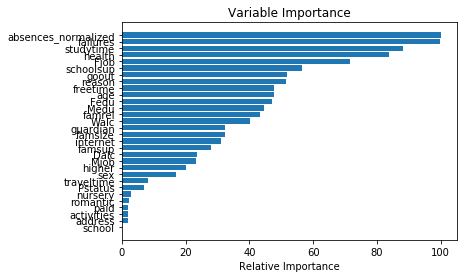

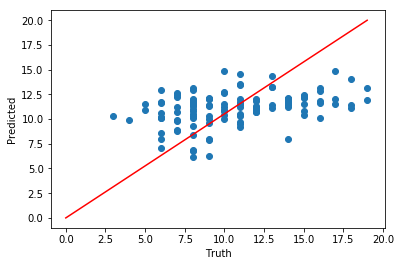

RMSE:  3.3203868516346917
R2:  0.2562450155440541


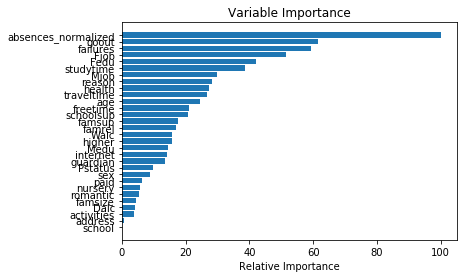

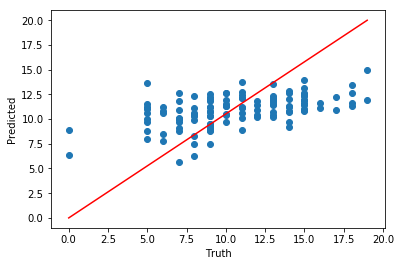

RMSE:  3.987435331695488
R2:  0.27669936050607113


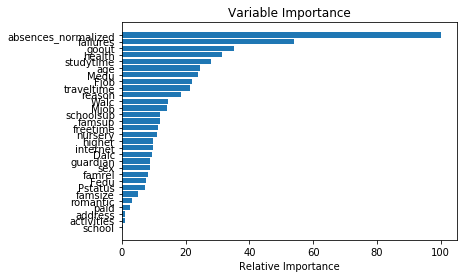

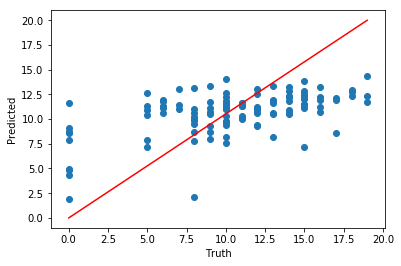

In [16]:
predict_grades(mat,target="G1")
predict_grades(mat,target="G2")
predict_grades(mat,target="G3")

RMSE:  2.6299681368715615
R2:  0.17006806620777426


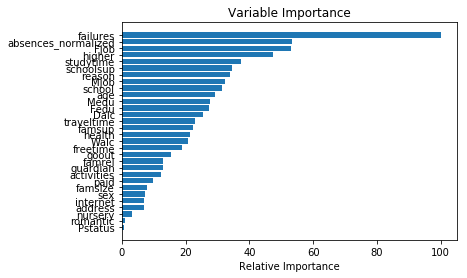

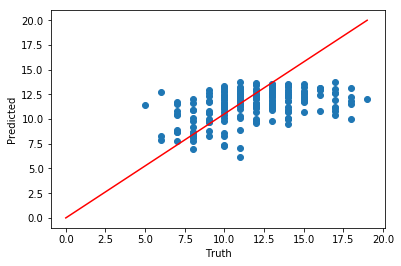

RMSE:  2.8082855901304242
R2:  0.20109188361015007


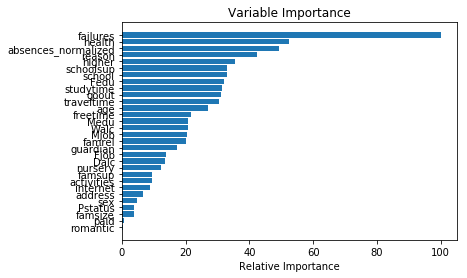

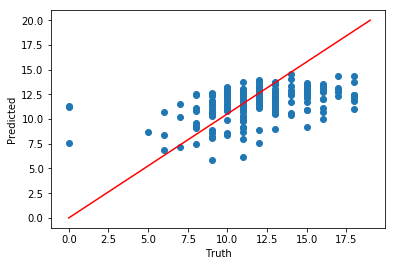

RMSE:  2.9023063323777483
R2:  0.23826452643927942


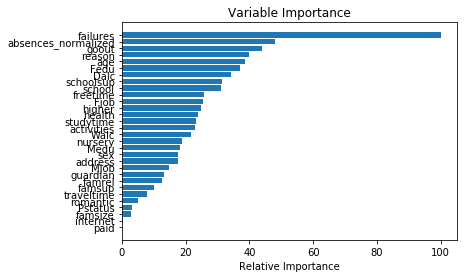

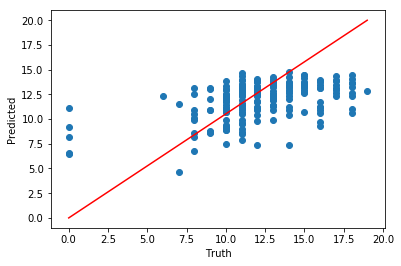

In [17]:
predict_grades(por,target="G1")
predict_grades(por,target="G2")
predict_grades(por,target="G3")

Se puede observar que el regresor tiene un "RMSE" cercanos y superiores a 3, mientras que "R2" tiene valores cercanos a 0.25, por lo que no se puede considerar un buen regresor. 

El dataset es utilizado en el artículo [USING DATA MINING TO PREDICT
SECONDARY SCHOOL STUDENT PERFORMANCE](http://www3.dsi.uminho.pt/pcortez/student.pdf), pero los autores solamente predicen la variable 'G3' y para ello utilizan las variables 'G1' y 'G2', por lo que se ha realizado el mismo experimento que en el artículo.

In [18]:
def predict_grades_with_G1G2(df, target=""):
    X = df.drop(["G3","G1_pass","G2_pass","G3_pass"], axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.3, random_state=42)
    clf = GradientBoostingRegressor(n_estimators=500,learning_rate=0.01)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test, y_pred)
    print("RMSE: ", np.sqrt(mse))
    print("R2: ", r2)
    
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.plot()
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    plt.plot(np.linspace(0, 20, num=20),'r-')
    plt.scatter(y_test,y_pred)
    plt.xlabel('Truth')
    plt.ylabel('Predicted')
    plt.show()

RMSE:  1.7011495568440482
R2:  0.868351311689867


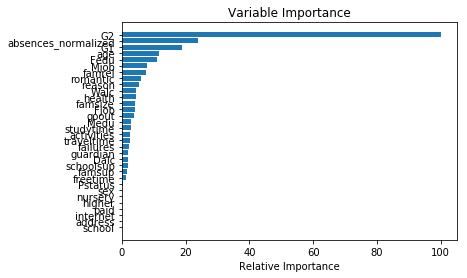

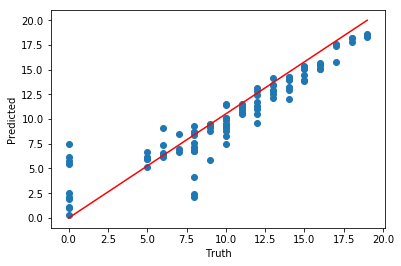

RMSE:  1.204449411218795
R2:  0.8688117890758643


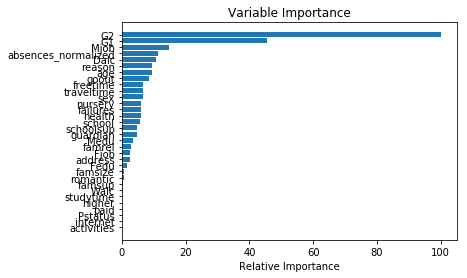

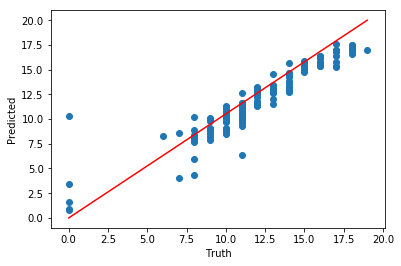

In [19]:
predict_grades_with_G1G2(mat,target="G3")
predict_grades_with_G1G2(por,target="G3")

Se observa que manteniendo las variables target 'G1' y 'G2', el regresor funciona con un RMSE mucho más bajo y el score 'R2' es muy competente. También se observa que las variables más importantes para predecir la variable 'G3' son (obviamente) 'G1' y 'G2'. Esto se puede explicar debido a la alta correlación que existe entre las tres variables *TARGET*. El resto de variables no tienen una importancia alta. 

### Clasificación

Aunque en el enunciado de la prueba se especificaba que podía realizarse la regresión o la clasificación, he decidido realizar los dos ejercicios. Se va a proceder a construir un clasificador usando GradientBoostingClassifier para predecir si las variables *TARGET* son iguales o superiores a 10. Para ello se crearon en el pretratamiento de los datos tres variables para cada fichero que indicaba si esta condición era cierta o no. Estas nuevas variables se llaman 'G[1|2|3]_pass'.

Para comprobar el correcto funcionamiento del clasificador se van a utilizar las medidas "Accuracy", "Precision" y "Recall" definidas en [Modern Information Retrieval](http://people.ischool.berkeley.edu/~hearst/irbook/print/chap10.pdf).

Como en el caso del regresor se muestra también la importancia relativa de cada variable para realizar la clasificación.

In [20]:
def predict_pass(df, target=""):
    print("Target: ", target)
    X = df.drop(["G1","G2","G3","G1_pass","G2_pass","G3_pass"], axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.3, random_state=42)
    clf = GradientBoostingClassifier(n_estimators=500)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)  
    rec = recall_score(y_test, y_pred)  
    
    print("Accuracy:  ", acc)
    print("Precision: ", prec)
    print("Recall: ", rec)
    
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.plot()
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

    print("-------------------------------------------------")

Target:  G1_pass
Accuracy:   0.6722689075630253
Precision:  0.6555555555555556
Recall:  0.8805970149253731


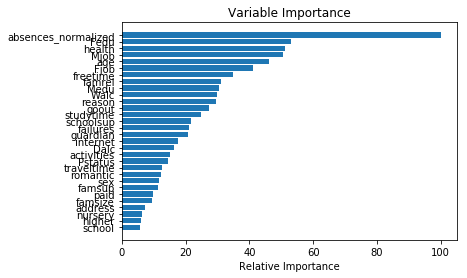

-------------------------------------------------
Target:  G2_pass
Accuracy:   0.6890756302521008
Precision:  0.6705882352941176
Recall:  0.8636363636363636


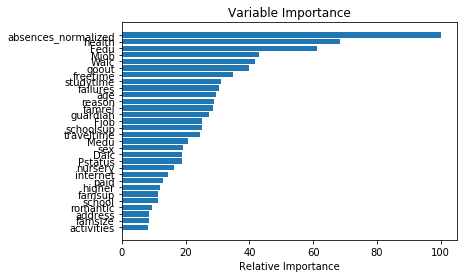

-------------------------------------------------
Target:  G3_pass
Accuracy:   0.6386554621848739
Precision:  0.6744186046511628
Recall:  0.7945205479452054


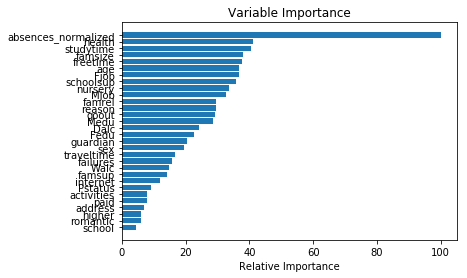

-------------------------------------------------


In [21]:
predict_pass(mat,"G1_pass")
predict_pass(mat,"G2_pass")
predict_pass(mat,"G3_pass")

Target:  G1_pass
Accuracy:   0.8205128205128205
Precision:  0.8641975308641975
Recall:  0.9150326797385621


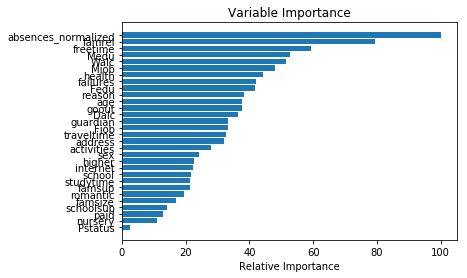

-------------------------------------------------
Target:  G2_pass
Accuracy:   0.8
Precision:  0.8402366863905325
Recall:  0.922077922077922


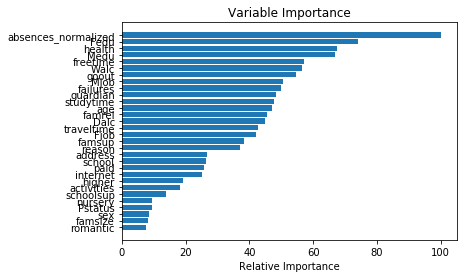

-------------------------------------------------
Target:  G3_pass
Accuracy:   0.8615384615384616
Precision:  0.9127906976744186
Recall:  0.9289940828402367


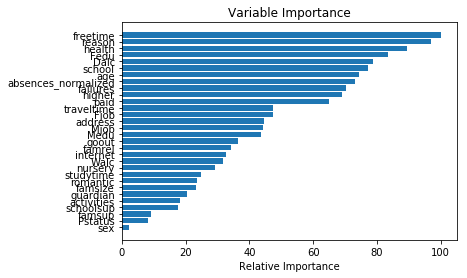

-------------------------------------------------


In [22]:
predict_pass(por,"G1_pass")
predict_pass(por,"G2_pass")
predict_pass(por,"G3_pass")

En el caso de **Matemáticas**, el clasificador se comporta de manera "razonable" con un accuracy entre el 0.6 y 0.7, con precision y recall balanceados.

En el caso de **Portugués**, el clasificador se comporta de manera excelente con un accuracy cercano al 0.9, con precision y recall también muy altos y balanceados.

Como en el caso del regresor, se va a realizar una comparación con la clasificación realizada en el artículo, prediciendo 'G3' manteniendo 'G1' y 'G2'.

In [23]:
def predict_pass_with_G1G2(df, target=""):
    print("Target: ", target)
    X = df.drop(["G3","G1_pass","G2_pass","G3_pass"], axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.3, random_state=42)
    clf = GradientBoostingClassifier(n_estimators=500)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)  
    rec = recall_score(y_test, y_pred)  
    
    print("Accuracy:  ", acc)
    print("Precision: ", prec)
    print("Recall: ", rec)
    
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.plot()
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

    print("-------------------------------------------------")

Target:  G3_pass
Accuracy:   0.865546218487395
Precision:  0.8701298701298701
Recall:  0.9178082191780822


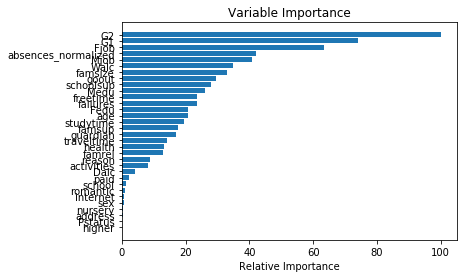

-------------------------------------------------
Target:  G3_pass
Accuracy:   0.9435897435897436
Precision:  0.9593023255813954
Recall:  0.9763313609467456


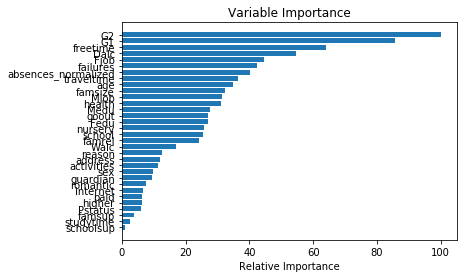

-------------------------------------------------


In [24]:
predict_pass_with_G1G2(mat,"G3_pass")
predict_pass_with_G1G2(por,"G3_pass")

Se observa igual que en el caso del regresor que la clasificación (obviamente) mejora, obteniendo resultados muy superiores a los mostrados en el artículo.